Data da publicação: 04/10/2021<br>
Tutorial escrito por Paula Luana Oliveira da Silva, graduanda em Ciência da Computação pela Universidade Federal do Ceará - Campus Quixadá.

# Predição de séries temporais com o ARIMA

## Introdução a Séries Temporais

### Definição
Séries temporais são dados coletados em intervalos regulares de tempo. Esses dados possuem dependência com a ordem e com eles podemos observar em que data esses dados decrescem ou crescem. Usamos séries temporais comumente para entender em que dias, meses ou anos, os valores são alterados e porque são alterados. Por exemplo, em uma sorveteria podemos analisar em que dias da semana as vendas são maiores, em quais meses as vendas aumentam e a partir disso podemos inferir informações, como que, os sorvetes vendem mais no verão.

### Padrões
Em séries temporais podemos extrair padrões, esses padrões são:<br>
**Sazonalidade:** Padrão que se repete.<br>
Exemplo: Em um terminal de ônibus durante a semana, a circulação de pessoas é maior às 19h da noite, que é o horário em que trabalhadores estão saindo do serviço.

**Ciclos:** Padrões que ocorrem eventualmente.<br>
Exemplo: No mesmo mesmo terminal de ônibus, em um feriado na semana, a circulação de pessoas decresce às 19h

**Tendência:** Nos ajuda a visualizar e entender qual a tendência dos nosso dados, se eles crescem no decorrer do tempo ou decrescem.<br> Exemplo: Em julho a circulação de pessoas aumentam no terminal, porque muitas pessoas estão de férias, então saem mais. Ou seja, em julho, nossos dados tendem positivamente.

**Ruídos:** São os dados que não se incluem nos padrões.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Conhecendo os dados originais

Com o crescimento exponencial de mortes causadas pela COVID-19, a criação de vacinas precisou ser o mais breve possível. Agora, com vários tipos de vacinas sendo aplicadas, a expectativa da população é que o progresso da vacinação seja rápido. Saber quando esse processo de vacinação vai acabar é uma tarefa difícil, já que cada país tem seu ritmo, suas variáveis e problemas políticos que podem desacelerar a vacinação. Dessa maneira, cada país possui um comportamento diferente quando se refere a quantidade de vacinas aplicadas por dia e o total de vacinas aplicadas.

Neste trabalho, os dados utilizados são coletas diárias sobre a quantidade de vacinas aplicadas em cada país e indicam o progresso da vacinação no mundo.  O conjunto de dados é apresentado na plataforma *Kaggle*(plataforma de aprendizado e prática de *Data Science*) como o problema [COVID-19 World Vaccination Progress](www.kaggle.com/gpreda/covid-world-vaccination-progress), no qual as coletas apresentadas no quadro de dados foram retiradas do repositório do GitHub do [Our World in Data](https://github.com/owid/covid-19-data)(publicação digital, especializada em dados analíticos). 

In [3]:
original_df = pd.read_csv('/content/drive/MyDrive/tutoriais/country_vaccinations.csv')
original_df

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://app.powerbi.com/view?r=eyJrIjoiYTkyM2V...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://app.powerbi.com/view?r=eyJrIjoiYTkyM2V...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://app.powerbi.com/view?r=eyJrIjoiYTkyM2V...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://app.powerbi.com/view?r=eyJrIjoiYTkyM2V...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://app.powerbi.com/view?r=eyJrIjoiYTkyM2V...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43140,Zimbabwe,ZWE,2021-09-03,4372216.0,2681657.0,1690559.0,48481.0,42317.0,28.97,17.77,11.20,2804.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...
43141,Zimbabwe,ZWE,2021-09-04,4400246.0,2698332.0,1701914.0,28030.0,41413.0,29.16,17.88,11.28,2744.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...
43142,Zimbabwe,ZWE,2021-09-05,4431599.0,2713248.0,1718351.0,31353.0,41964.0,29.36,17.98,11.39,2781.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...
43143,Zimbabwe,ZWE,2021-09-06,NaN,NaN,NaN,NaN,41445.0,NaN,NaN,NaN,2746.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...


In [4]:
original_df.columns

Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')

In [5]:
original_df.shape

(43145, 15)

### Dados que serão utilizados

Como estamos em tutorial de introdução à predição de séries temporais, vamos trabalhar com esses dados de uma maneira menor. Vamos trabalhar apenas com as coletas de vacinação diária do Brasil a partir da data em que o total de vacinações no Brasil é maior que zero.

In [6]:
df = pd.read_csv('/content/drive/MyDrive/tutoriais/df.csv', index_col='date')
df.index = pd.DatetimeIndex(df.index).to_period('D')
df

,daily_vaccinations
date,
2021-01-17,112
2021-01-18,554
2021-01-19,3823
2021-01-20,7136
2021-01-21,27304
...,...
2021-07-08,1242514
2021-07-09,1307672
2021-07-11,1307796


### Identificando padrões

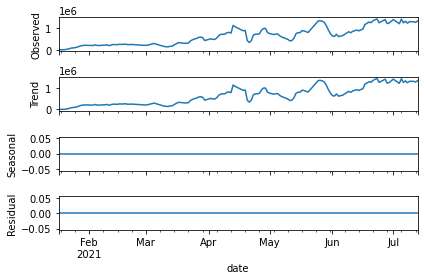

In [7]:
decompose = seasonal_decompose(df, freq = 1)

decompose.plot();

Já podemos fazer predição utilizando a série? **Não!**<br>
Para construir um modelo de série temporal é necessário que a série seja estacionária. Em casos que a série não é estacionária, a primeira coisa que devemos fazer é torna-la estacionária, em seguida, tentar modelos estocásticos para prever essa série temporal.

### Série estacionária
Uma série é estacionária quando suas propriedades estatísticas permanecem constantes. Mais especificamente, uma série é estacionária se satisfazer as seguintes condições.


1.   A média da série não deve ser uma função do tempo, mas sim uma constante.
2.   A variação da série não deve ser função do tempo.
3.   A covariância do i ésimo termo e do (i + m) ésimo termo não deve ser função do tempo. 

### Como saber se a série é estacionária?
Usando o **teste de Dickey-Fuller**! Este é um teste do tipo Hipótese de Raiz Unitária no qual ele tenta determinar o quão forte a série temporal é definida por uma tendência.

Basicamente vamos ter uma tabela que apresentará o que chamamos de valor critico, que é uma espécie de valor de corte. Em nosso exemplo são exibidos níveis de 1%, 5% e 10%. Se o resultado do ADF for menor do que o valor critico para um determinado percentual (5% no nosso caso) e o p-value for significante (menor que 0.05), a série é considerada estacionária. Do contrário a série é não estacionária.



In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
resultados = adfuller(df.daily_vaccinations)
resultados

(-1.354481576381638,
 0.6038934121448093,
 0,
 153,
 {'1%': -3.473829775724492,
  '10%': -2.5769448985432954,
  '5%': -2.880622899711496},
 3610.4031419280886)

In [10]:
output = pd.Series(resultados[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
output

Estatística do teste                     -1.354482
p-value                                   0.603893
O critério de informação maximizado       0.000000
Número de observações usadas            153.000000
dtype: float64

Com as condições que temos sobre uma série ser estacionária, vamos criar uma função simples que verifica isso para gente.

In [11]:
def ehEstacionaria(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    
    if(dfoutput['Estatística do teste'] < dfoutput['Valor crítico (5%)'] and dfoutput['p-value'] < 0.05):
        print('É estacionária.')
    else:
        print('Não é estacionária.')

In [12]:
ehEstacionaria(df.daily_vaccinations)

Não é estacionária.


### Como tornar a série estacionária?
As técnicas usadas para conseguir uma série estacionária, são, transformações (logarítmica, a raiz quadrada, boxcox), diferenciação, etc. Vamos começar com o método da diferenciação. Esse processo cria uma nova série a partir da diferença de uma observação com a observação anterior.

Através da diferenciação também é possível remover a dependência temporal de uma série, reduzindo a tendência e a sazonalidade. Por esse motivo esse método pode ser usado para atingir a estacionariedade. Pode-se diferenciar uma série mais de uma vez, caso seja necessário para remover a dependência.

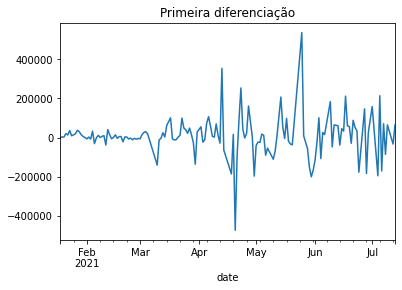

In [13]:
dfdiff = df.daily_vaccinations.diff()
dfdiff = dfdiff.dropna()
plt.title("Primeira diferenciação")
dfdiff.plot()
plt.show()

In [14]:
ehEstacionaria(dfdiff)

É estacionária.


### Aplicação prática utilizando o ARIMA

Média Móvel Integrada Autoregressiva (ARIMA)

O modelo ARIMA(AutoRegressive Integrated Moving Average model) utiliza métodos de diferenciação para tornar a série temporal em estacionária(as propriedades estatísticas são constantes), aplica modelos de autoregressão e média móvel. Ou seja, o modelo que é estacionário, sua média, variância e autocovariância são invariáveis em relação ao tempo. **O método é adequado para séries temporais univariadas com tendência e sem componentes sazonais.**

**Parâmetros**<br>
Na função ARIMA do python, passamos três parâmetros, sendo eles: <br>
p: é a ordem do modelo autoregressivo; Mais especificamente é quantidade de lags(quantidade de valores correlacionados)<br>
d: o número de vezes que as observações serão diferenciadas.<br>
q: é a ordem do modelo de média móvel.


## Mãos na massa

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import random
from sklearn.metrics import mean_absolute_error as mae

Inicialmente, escolheremos quais serão nossos dados de treino e teste. Vamos treinar com 15 dias consecutivos para tentar descobrir o valor do dia seguinte. A escolha da data acontecerá aleatoriamente, mas se você preferir, você pode seleionar a dedo.

In [16]:
X = df['daily_vaccinations'].values
len_days = 15
days_predict = len_days + 1

In [17]:
#Separar os dados em treino e teste.
check = False
drawn_number = -1
while (check == False):
  drawn_number = random.randrange(0,len(df)-1)
  if (drawn_number+len_days) <= (len(df)-1):
    check = True
drawn_number

108

In [18]:
train = X[drawn_number:drawn_number+len_days]

In [19]:
train.size

15

In [20]:
train

array([ 795659,  894140,  876967,  844329,  807435, 1344045, 1352814,
       1329775, 1273730, 1123150,  922807,  756893,  643380,  621607,
        723103])

In [21]:
test = X[drawn_number+len_days:drawn_number+days_predict]

In [22]:
test

array([615884])

In [23]:
model = ARIMA(train, order=(10,1,1))

# treina o modelo ARIMA
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
valor_predito = model_fit.forecast()[0]
valor_predito

array([1200018.75784288])

In [25]:
print(test, valor_predito)

[615884] [1200018.75784288]


### Análise do modelo
Podemos analisar o modelo aplicando a função mean_absolute_error e passando como parâmetro o valor real e o valor predito.

In [26]:
mae([test], valor_predito)

584134.7578428779

## Referências

[Dicas para criar um modelo de previsão de séries temporais](https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148)

[Modelos ARIMA](http://sillasgonzaga.com/material/curso_series_temporais/arima.html)

[Prevendo Vendas com ARIMA - Passo a Passo com Python](https://www.youtube.com/watch?v=v7rZpT8NCbk)



